In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import permutations
import itertools



In [2]:
def get_sorted_substitutions(distances_df):
    substitutions = {}
    amino_acids = distances_df.index

    for i, source_acid in enumerate(amino_acids):
        for j, target_acid in enumerate(amino_acids):
            if i < j:
                distance = distances_df.loc[source_acid, target_acid]
                substitutions[(source_acid, target_acid)] = distance

    sorted_substitutions = dict(sorted(substitutions.items(), key=lambda x: x[1]))
    return sorted_substitutions

In [16]:
def get_sorted_substitutions(distances_df):
    substitutions = {}
    amino_acids = distances_df.index

    for i, source_acid in enumerate(amino_acids):
        for j, target_acid in enumerate(amino_acids):
            if i < j:
                distance = distances_df.loc[source_acid, target_acid]
                substitutions[(source_acid, target_acid)] = distance

    sorted_substitutions = dict(sorted(substitutions.items(), key=lambda x: x[1]))

    # Convert to DataFrame
    data = []
    for (source_acid, target_acid), distance in sorted_substitutions.items():
        data.append({'aa1': source_acid, 'aa2': target_acid, 'cost': distance})
    
    df = pd.DataFrame(data)
    return df

In [15]:
def get_all_combinations(subset_df, max_subset_len):
    # Generate combinations of row indices
    combinations = []
    for r in range(2, max_subset_len):
        combinations.extend(list(itertools.combinations(range(len(subset_df)), r)))

    # Create a list of new rows
    new_rows = []
    for comb in combinations:
        aa1 = ''.join(subset_df.loc[i, 'aa1'] for i in comb)
        aa2 = ''.join(subset_df.loc[i, 'aa2'] for i in comb)
        cost = sum(subset_df.loc[i, 'cost'] for i in comb)
        new_rows.append({'aa1': aa1, 'aa2': aa2, 'cost': cost})

    # Concatenate new rows to the DataFrame
    subset_df = pd.concat([subset_df, pd.DataFrame(new_rows)], ignore_index=True)

    print(subset_df)

In [5]:
def get_subset_df(sorted_amino, seq):

    letters = list(seq)

    # Create a DataFrame to hold the filtered rows
    filtered_df = pd.DataFrame(columns=sorted_amino.columns)

    for letter in letters:
        # Filter rows where the letter appears in aa1 or aa2
        temp_df = sorted_amino[(sorted_amino['aa1'] == letter) | (sorted_amino['aa2'] == letter)]

        # Append filtered rows to the result DataFrame
        filtered_df = pd.concat([filtered_df, temp_df.astype(str)], ignore_index=True)

    return filtered_df


In [6]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)

sorted_amino_df = get_sorted_substitutions(distances_df)

In [13]:
seq = "F"

subset_df = get_subset_df(sorted_amino_df, seq)

# get_all_combinations(subset_df, len(subset_df)+1)

/tmp/ipykernel_252546/4176258298.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df, temp_df])


In [14]:
subset_df

,aa1,aa2,cost
0,F,I,0.949239
3,F,M,1.451638
14,F,T,2.099105
19,F,W,2.316303
23,F,Y,2.545206
24,F,N,2.547747
37,E,F,2.884447
45,C,F,3.104613
52,F,G,3.246019
59,F,K,3.381667


In [95]:
import pandas as pd

data = {'aa1': ['C', 'F', 'A'],
        'aa2': ['F', 'I', 'G'],
        'cost': [1, 3, 4]}

df = pd.DataFrame(data)

letters = ["C", "C", "A"]

# Create a DataFrame to hold the filtered rows
filtered_df = pd.DataFrame(columns=df.columns)

for letter in letters:
    # Filter rows where the letter appears in aa1 or aa2
    temp_df = df[(df['aa1'] == letter) | (df['aa2'] == letter)]
    
    # Append filtered rows to the result DataFrame
    filtered_df = pd.concat([filtered_df, temp_df])


print(filtered_df)


  aa1 aa2 cost
0   C   F    1
0   C   F    1
2   A   G    4


In [14]:
sorted_amino_df

,aa1,aa2,cost
0,F,I,0.949239
1,A,L,1.248024
2,L,V,1.284128
3,F,M,1.451638
4,D,Q,1.630393
...,...,...,...
185,S,T,8.096340
186,D,Y,8.333166
187,M,S,8.668166
188,R,S,8.673774


In [12]:
def find_closest_sum_pandas(df, target):
    min_diff = float('inf')
    closest_sum = None
    closest_combination = None

    for r in range(2, len(df) + 1):
        for combination in itertools.combinations(df.iterrows(), r):
            selected_rows = [row[1] for row in combination]
            aa1 = ''.join(selected_rows['aa1'])
            aa2 = ''.join(selected_rows['aa2'])
            cost_sum = sum(selected_rows['cost'].fillna(0))
            diff = cost_sum - target
            if diff > 0 and diff < min_diff:
                min_diff = diff
                closest_sum = cost_sum
                closest_combination = (aa1, aa2)

    if closest_combination:
        closest_comb_df = pd.DataFrame({'aa1': [closest_combination[0]], 'aa2': [closest_combination[1]], 'cost': [closest_sum]})
    else:
        closest_comb_df = pd.DataFrame(columns=['aa1', 'aa2', 'cost'])

    return closest_comb_df

target = 1
closest_comb_df = find_closest_sum_pandas(sorted_amino, target)
print(closest_comb_df)

Traceback (most recent call last):
  File "/home/chen/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1
    ((0, aa1            Faa2...pe: object), (1, aa1            Aaa2...pe: object))
         ^^^^^^^^^^^^^^^^^^^
SyntaxError: invalid syntax. Perhaps you forgot a comma?


TypeError: list indices must be integers or slices, not str

In [15]:
import itertools

data = sorted_amino

# Create a list of all keys
# data = dict(list(sorted_amino.items())[:150])
keys = list(data.keys())



# Function to generate combinations with replacement up to a maximum length
def generate_combinations(keys, max_length):
    sums = {key: data[key] for key in keys}  # Dictionary to store cumulative sums
    for r in range(2, max_length + 1):
        for perm in itertools.combinations_with_replacement(keys, r):
            sum_val = sum(sums[key] for key in perm)
            amino_sub.append((perm, sum_val))
            # Update sums for next iteration
            for key in perm:
                sums[key] += data[key]

# Generate combinations with replacement up to length 5
max_length = 4
amino_sub = []
generate_combinations(keys, max_length)

: 

In [ ]:
import itertools

data = sorted_amino  # Assuming sorted_amino is the original data dictionary

# Get all combinations with replacement of length 2 to 5
amino_sub = [
    ([key for key in perm], sum(data[key] for key in perm))
    for r in range(2, 6)
    for perm in itertools.combinations_with_replacement(data, r)
]

In [3]:
def seq_to_dict(seq):
    result_dict = {}
    for idx, char in enumerate(seq):
        if char in result_dict:
            result_dict[char].append(idx)
        else:
            result_dict[char] = [idx]
    return result_dict


In [ ]:

def letter_permutations(string, letters, length):
    indexes = [(i, char) for i, char in enumerate(string) if char in letters]
    result = []
    for perm in permutations(indexes, length):
        if len(set(item[1] for item in perm)) == len(letters):
            result.append([(item[1], item[0]) for item in perm])
    # Convert the list of lists into a set of tuples and back to a list to remove duplicates
    result = list(set(tuple(sorted(perm)) for perm in result))
    return [list(perm) for perm in result]

# Example usage:
string = "FAFFB"
letters = ['F', 'F']
print(letter_permutations(string, set(letters), len(letters)))

In [23]:
from tqdm import tqdm

def find_couples(sequences_set, sorted_amino, max_neighbors=1):
    couples = {}
    for seq in tqdm(sequences_set, desc="Progress", unit=" sequence"):
        dict_seq = seq_to_dict(seq)
        couples[seq] = []
        flag = 0
        for sub in sorted_amino:
            if sub[0] not in dict_seq:
                continue

            if flag < max_neighbors:
                for occ in dict_seq[sub[0]]:
                    seq_to_search = seq[:occ] + sub[1] + seq[occ + 1:]
                    distance = sub[2]
                    if seq_to_search in sequences_set:
                        couples[seq].append([seq_to_search, distance])
                        flag += 1
                        if flag < max_neighbors:
                            break
            else:
                break

    return couples


In [4]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)

sorted_amino = get_sorted_substitutions(distances_df)

In [17]:
# read distance matrix

sequences_csv = '../files/forchen_F_26L.csv'
sequences_header = "cdr3_amino_acid"

# sequences_csv = '../files/for_chen_B.csv'
# sequences_header = "CDR3.aa"

# sequences_csv = "../random_sequences.csv"
# sequences_header = "sequences"

sequences_df = pd.read_csv(sequences_csv)

sequences_set = set(sequences_df[sequences_header].unique())

# sequences_set.add("CASSLALAGGTDTQYI")
# sequences_set.add("CASSLALAGGTDTQYC")

sorted_amino = get_sorted_substitutions(distances_df)
couples = find_couples(sequences_set, sorted_amino, max_neighbors=1)


Progress:   4%|▍         | 42930/1000746 [00:15<05:53, 2709.35 sequence/s]


KeyboardInterrupt: 

In [32]:
import json

with open("../couples.json") as json_file:
    couples = json.load(json_file)


In [18]:
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    for neighbor, weight in neighbors:
        G.add_edge(node, neighbor, weight=weight)

In [19]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

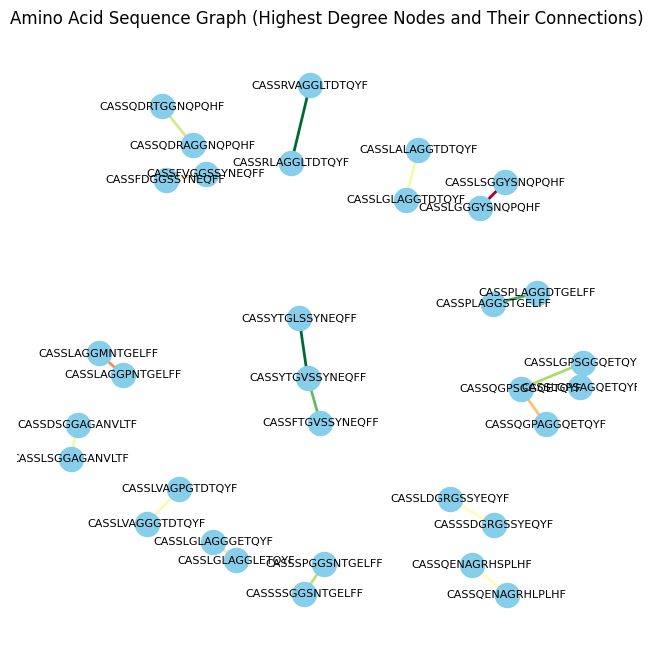

In [14]:

edge_colors = get_edges_colors(G)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()

### Highest degree node

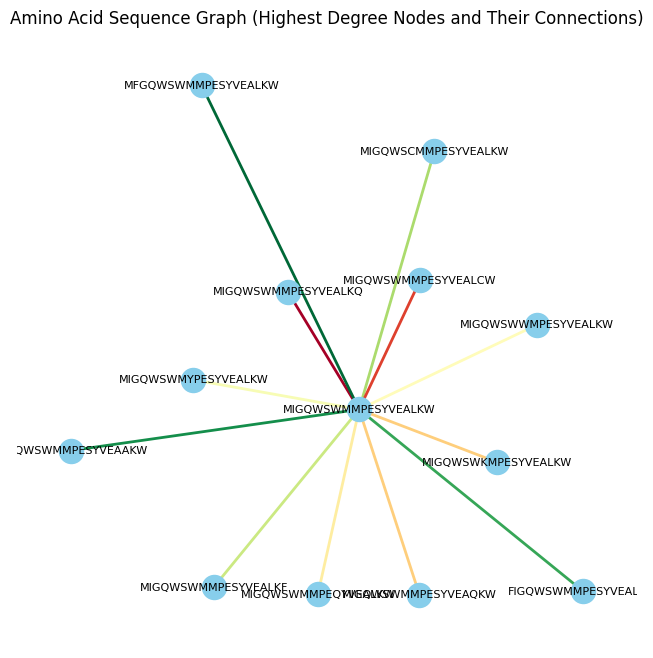

In [20]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()


### Longest path

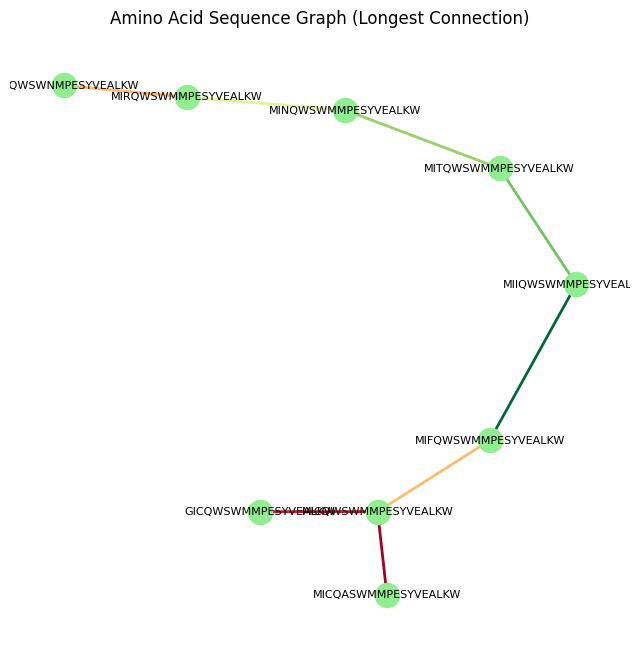

In [21]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_longest_connection.png')
plt.show()